In [5]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = yf.download('spy', start='2010-01-05')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.084984,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.149803,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.538841,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,92.846756,126402800
2010-01-11,115.080002,115.129997,114.239998,114.730003,92.976433,106375700


In [55]:
data = df.Close.values
dim = data.shape[0]

X = np.arange(0,dim)
y = data 

SS =  MinMaxScaler() #StandardScaler()
y_normalized = SS.fit_transform(y.reshape(-1,1))

print(data.shape)

(2672,)


In [12]:
# checkpoint_filepath = '/tmp/checkpoint' # model.load_weights(checkpoint_filepath)
# MC = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
#                       monitor='loss', mode='max', save_best_only=True)

In [48]:
nodes = 1000

model = Sequential()
model.add(Dense(nodes*3, 'elu', input_shape=(1,)))
model.add(GaussianNoise(0.1))
model.add(Dense(nodes, 'elu'))
model.add(LayerNormalization())  # without loss: 118.0249
# model.add(BatchNormalization())

model.add(Dense(100, 'elu'))
model.add(Dense(1))

model.compile(optimizer=Adam(0.00005), loss ='mse') # mae

ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights= True)
model.fit(X, y, batch_size= 100, epochs= 200, callbacks= [ES], validation_split= 0.10)

Train on 2404 samples, validate on 268 samples
Epoch 1/200
2404/2404 [==============================] - 2s 664us/sample - loss: 33086.8305 - val_loss: 73289.6283
Epoch 2/200
2404/2404 [==============================] - 1s 245us/sample - loss: 26008.6149 - val_loss: 66950.5764
Epoch 3/200
2404/2404 [==============================] - 1s 314us/sample - loss: 23326.6829 - val_loss: 63014.5882
Epoch 4/200
2404/2404 [==============================] - 1s 354us/sample - loss: 21222.4984 - val_loss: 59337.0015
Epoch 5/200
2404/2404 [==============================] - 1s 357us/sample - loss: 19282.4558 - val_loss: 55793.0151
Epoch 6/200
2404/2404 [==============================] - 1s 369us/sample - loss: 17461.9261 - val_loss: 52393.7502
Epoch 7/200
2404/2404 [==============================] - 1s 360us/sample - loss: 15725.1885 - val_loss: 49008.3790
Epoch 8/200
2404/2404 [==============================] - 1s 351us/sample - loss: 14074.8263 - val_loss: 45704.9356
Epoch 9/200
2404/2404 [==========

In [49]:
y_hat = model.predict(X)
print(y_hat.shape)
print(y_hat[:5])

(2672, 1)
[[208.38092 ]
 [131.63777 ]
 [115.48859 ]
 [111.215385]
 [110.22627 ]]


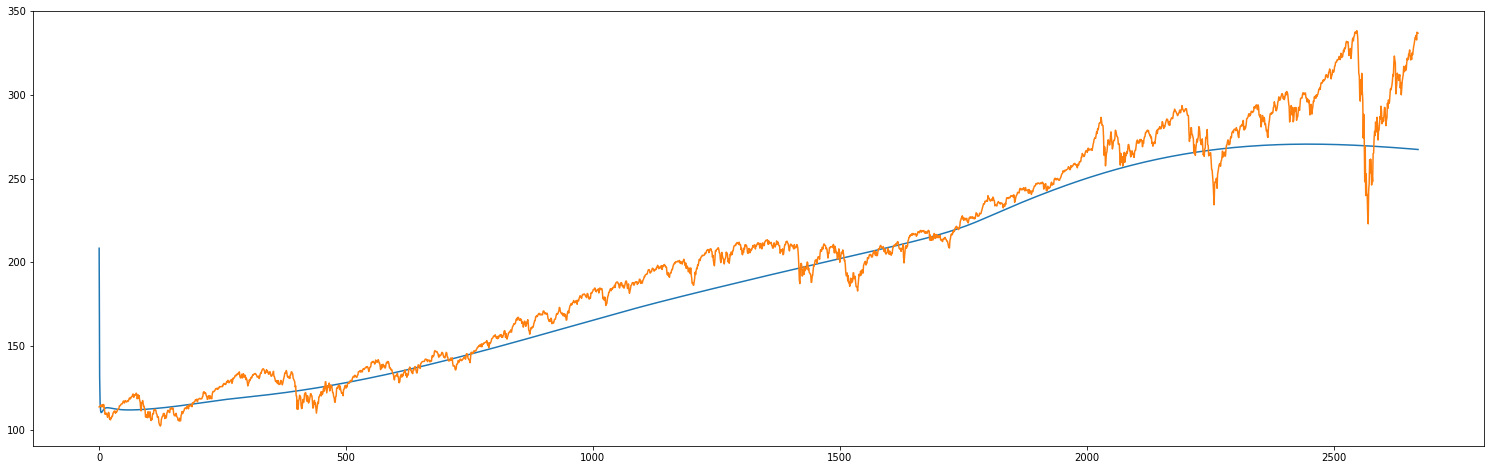

In [50]:
plt.figure(figsize=(26,8))
plt.plot(y_hat)
plt.plot(y)

In [143]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length]
        dataX.append(_x)
    return np.array(dataX)

# tmp = MinMaxScaler().fit_transform(X.reshape(-1, 1))
# tmp.reshape(1,-1)[0]

X_lstm = build_dataset(tmp,20)
X_lstm = X_lstm.reshape((X_lstm.shape[0], 1, X_lstm.shape[1]))
dim = X_lstm.shape[0]

y_lstm = y[20:] 
y_lstm = MinMaxScaler().fit_transform(y_lstm.reshape(-1, 1))
y_lstm = y_lstm.reshape(1,-1)[0]

y_lstm = y_lstm[20:] 
y_lstm

array([0.04421107, 0.05102906, 0.05111374, ..., 0.99618873, 0.99360545,
       0.99364784])

In [144]:
print(X_lstm.shape)
print(len(y_lstm))
print(dim)

(2632, 1, 20)
2632
2632


In [187]:
nodes = 200
model = Sequential()

model.add(LSTM(1000, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(BatchNormalization())
model.add(Dense(1000, 'elu')) 

model.add(Dense(nodes, 'elu')) 
model.add(Dense(nodes, 'elu'))

model.add(Dense(100, 'elu'))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss ='mse') # mae # 0.0005

ES = EarlyStopping(monitor='loss', patience=5, restore_best_weights= True)
model.fit(X_lstm, y_lstm, batch_size= 16, epochs= 10, callbacks= [ES]) #  

Epoch 1/10
2632/2632 [==============================] - 15s 6ms/sample - loss: 0.2839
Epoch 2/10
2632/2632 [==============================] - 11s 4ms/sample - loss: 0.0048
Epoch 3/10
2632/2632 [==============================] - 11s 4ms/sample - loss: 0.0063
Epoch 4/10
2632/2632 [==============================] - 11s 4ms/sample - loss: 0.0056
Epoch 5/10
2632/2632 [==============================] - 10s 4ms/sample - loss: 0.0040
Epoch 6/10
2632/2632 [==============================] - 11s 4ms/sample - loss: 0.0036
Epoch 7/10
2632/2632 [==============================] - 11s 4ms/sample - loss: 0.0028
Epoch 8/10
2632/2632 [==============================] - 10s 4ms/sample - loss: 0.00260s - loss: 0.00
Epoch 9/10
2632/2632 [==============================] - 11s 4ms/sample - loss: 0.0027
Epoch 10/10
2632/2632 [==============================] - 11s 4ms/sample - loss: 0.0035


array([[0.01609243],
       [0.01622672],
       [0.01757444],
       ...,
       [0.9746294 ],
       [0.98193085],
       [0.984548  ]], dtype=float32)

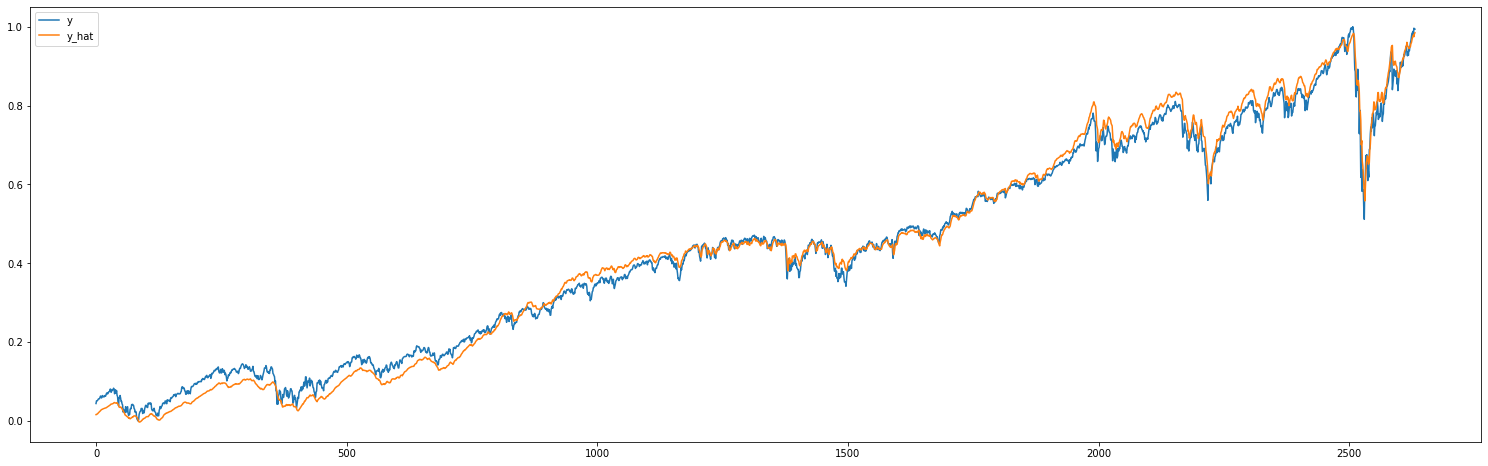

In [188]:
y_hat = model.predict(X_lstm)
# y_hat = y_hat.reshape(1,-1)[0]
# y_hat *= -1
# y_hat += 0.7

plt.figure(figsize=(26,8))
plt.plot(y_lstm, label = 'y')
plt.plot(y_hat, label = 'y_hat')
plt.legend()
y_hat

In [198]:
nodes = 200
model = Sequential()

# model.add(LSTM(1000, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(TimeDistributed(Dense(1000), input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(1000))) 

model.add(Dense(nodes, 'elu'))
model.add(Dense(nodes, 'elu'))

model.add(Dense(100, 'elu'))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss ='mse') # mae # 0.0005

ES = EarlyStopping(monitor='loss', patience=5, restore_best_weights= True)
model.fit(X_lstm, y_lstm, batch_size= 16, epochs= 30, callbacks= [ES]) #  

Epoch 1/30
2632/2632 [==============================] - 5s 2ms/sample - loss: 0.9254
Epoch 2/30
2632/2632 [==============================] - 2s 817us/sample - loss: 0.0888
Epoch 3/30
2632/2632 [==============================] - 2s 919us/sample - loss: 0.0748
Epoch 4/30
2632/2632 [==============================] - 3s 984us/sample - loss: 0.0768
Epoch 5/30
2632/2632 [==============================] - 2s 946us/sample - loss: 0.0807
Epoch 6/30
2632/2632 [==============================] - 3s 956us/sample - loss: 0.0793
Epoch 7/30
2632/2632 [==============================] - 2s 929us/sample - loss: 0.0745
Epoch 8/30
2632/2632 [==============================] - 3s 986us/sample - loss: 0.0729
Epoch 9/30
2632/2632 [==============================] - 2s 900us/sample - loss: 0.0749
Epoch 10/30
2632/2632 [==============================] - 2s 917us/sample - loss: 0.0744s - loss: 0.
Epoch 11/30
2632/2632 [==============================] - 2s 929us/sample - loss: 0.0730
Epoch 12/30
2632/2632 [========

array([0.15055943, 0.15181875, 0.15419984, ..., 0.2996334 , 0.29978174,
       0.30258733], dtype=float32)

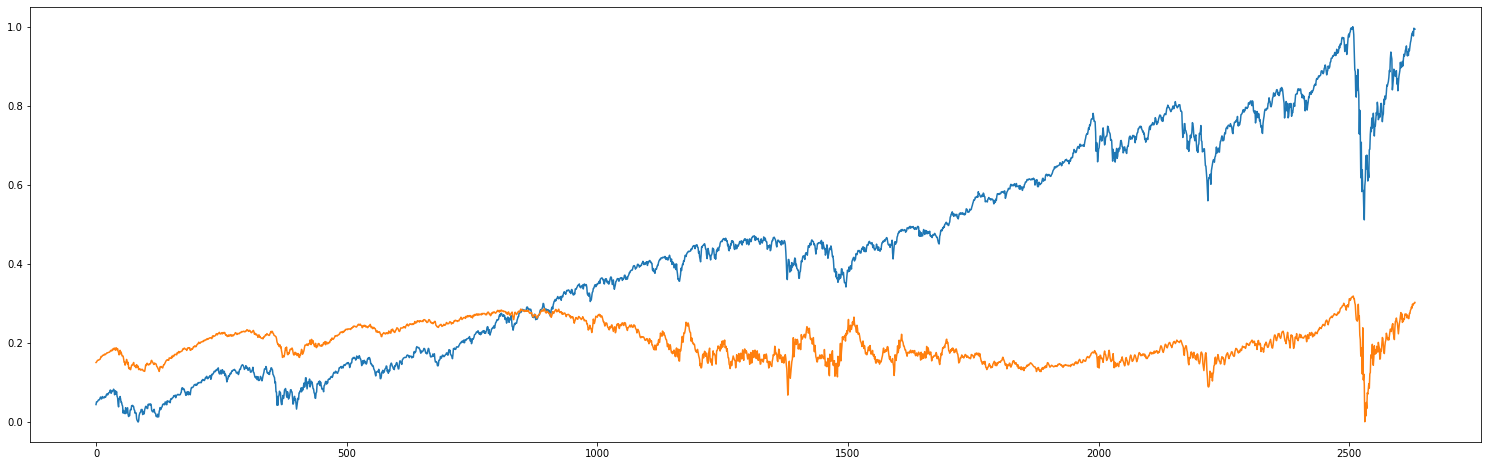

In [199]:
y_hat = model.predict(X_lstm)
y_hat = y_hat.reshape(1,-1)[0]
y_hat *= -1
y_hat += 0.7

plt.figure(figsize=(26,8))
plt.plot(y_lstm)
plt.plot(y_hat)
y_hat

In [195]:
model.evaluate(X_lstm,y_lstm)

2632/2632 [==============================] - 1s 466us/sample - loss: 0.0693


0.06927890905995052

In [ ]:
# y_normalized

In [ ]:
# SS.inverse_transform(y_hat)